In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
from user.informed_user import InformedUser
from pool.simple_pool import SimplePool
from pool.abstract_pool import PoolLiquidityState
from prices_snapshot import PricesSnapshot

pool = SimplePool(
    liquidity_state=PoolLiquidityState(
        quantity_a=1715,
        quantity_b=8106,
    ),
    alpha=0.1,
)

prices = PricesSnapshot(
    price_a=2533, # ETHUSDT
    price_b=70202, # BTCUSDT
)

In [3]:
import numpy as np
from common import get_amm_exchange_value_a_to_b, capital_function
from user_action import construct_user_swap_a_to_b, construct_user_swap_b_to_a, UserAction
import matplotlib.pyplot as plt
import seaborn as sns

possible_actions: list[tuple[UserAction, bool, float]] = []

LIMIT = 70000

for dx in np.arange(0, LIMIT, 100):
    action = construct_user_swap_a_to_b(
        pool_state=pool.liquidity_state, fee_rate=pool.get_a_to_b_exchange_fee_rate(), amount_to_exchange_A=dx
    )
    if action is None:
        continue
    deal_markout = capital_function(action.delta_x, action.delta_y, prices=prices)
    print(f"Action: {action}, markout: {deal_markout}")
    possible_actions.append((action, False, deal_markout)) 

for dy in np.arange(0, LIMIT, 100):
    action = construct_user_swap_b_to_a(
        pool_state=pool.liquidity_state, fee_rate=pool.get_b_to_a_exchange_fee_rate(), amount_to_exchange_B=dy
    )
    if action is None:
        continue
    deal_markout = capital_function(action.delta_x, action.delta_y, prices=prices)
    possible_actions.append((action, True, deal_markout))

Action: UserAction(delta_x=np.int64(0), delta_y=np.float64(-0.0), fee_x=np.float64(0.0), fee_y=0), markout: 0.0
Action: UserAction(delta_x=np.int64(-100), delta_y=np.float64(404.17728531855937), fee_x=np.float64(10.0), fee_y=0), markout: 28120753.783933505
Action: UserAction(delta_x=np.int64(-200), delta_y=np.float64(769.9630606860155), fee_x=np.float64(20.0), fee_y=0), markout: 53546346.78627966
Action: UserAction(delta_x=np.int64(-300), delta_y=np.float64(1102.579345088161), fee_x=np.float64(30.0), fee_y=0), markout: 76643375.18387908
Action: UserAction(delta_x=np.int64(-400), delta_y=np.float64(1406.3421686746988), fee_x=np.float64(40.0), fee_y=0), markout: 97714832.92530121
Action: UserAction(delta_x=np.int64(-500), delta_y=np.float64(1684.8498845265585), fee_x=np.float64(50.0), fee_y=0), markout: 117013331.59353346
Action: UserAction(delta_x=np.int64(-600), delta_y=np.float64(1941.1263858093125), fee_x=np.float64(60.0), fee_y=0), markout: 134751154.53658536
Action: UserAction(delt

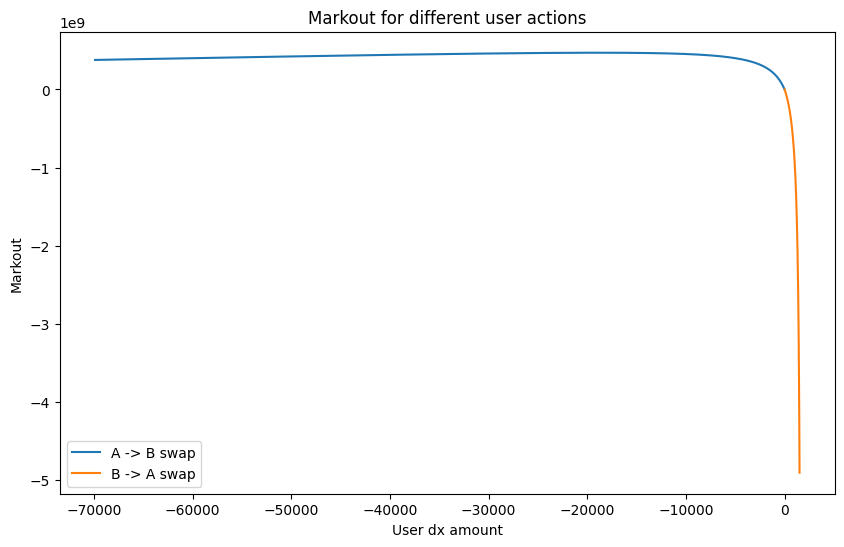

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

possible_actions = sorted(possible_actions, key=lambda x: x[0].delta_x)

a_to_b_actions = [x for x in possible_actions if not x[1]]
b_to_a_actions = [x for x in possible_actions if x[1]]

sns.lineplot(
    x=[x[0].delta_x for x in a_to_b_actions],
    y=[x[2] for x in a_to_b_actions],
    ax=ax,
    label='A -> B swap'
)

sns.lineplot(
    x=[x[0].delta_x for x in b_to_a_actions],
    y=[x[2] for x in b_to_a_actions],
    ax=ax,
    label='B -> A swap'
)

ax.set_xlabel('User dx amount')
ax.set_ylabel('Markout')
plt.title('Markout for different user actions')
plt.legend()
plt.show()

In [5]:
best_action = max(possible_actions, key=lambda x: x[2])

print(f'Best action (bruteforce): {best_action[0]}, markout: {best_action[2]}')

Best action (bruteforce): UserAction(delta_x=np.int64(-18800), delta_y=np.float64(7359.995707002951), fee_x=np.float64(1880.0), fee_y=0), markout: 469066018.6230212


In [6]:
informed_user_action = InformedUser().get_user_action(
    pool=pool,
    network_fee=0,
    prices=prices
)

In [7]:
informed_user_action_markout = capital_function(informed_user_action.delta_x, informed_user_action.delta_y, prices=prices)

print(f'Best action (theoretical): {informed_user_action}, markout: {informed_user_action_markout}')

Best action (theoretical): UserAction(delta_x=np.float64(-19904.15992773454), delta_y=np.float64(7397.76364794085), fee_x=np.float64(1990.4159927734543), fee_y=0), markout: 468920566.51579195
